In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage import io
from skimage import img_as_ubyte
import cv2 as cv

/var/folders/0y/xzwy9cz54g9b7ghtkf3shzlh0000gn/T/ipykernel_50393/1936212296.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [78]:
PATCH_SIZE = 35

# Adding the image and convert it into grey color image:-
img = cv.imread('mt_everst.jpg',2)
re_img = cv.resize(img,(1700,1700))
cv.imshow('Mountain Resize',re_img)
cv.waitKey(0)
cv.destroyAllWindows()
cv.waitKey(1)

-1

In [61]:
GLCM = graycomatrix(img,[1],[0,np.pi/4,np.pi/2,3*np.pi/4])
a = graycoprops(GLCM,'energy')[0,0]
a

0.03595763856226541

In [62]:
from skimage import exposure

In [63]:
cell_location = [(100,100),(850,850),(670,850),(1600,850)]
cell_patches = []
for loc in cell_location:
    cell_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,loc[1]:loc[1] + PATCH_SIZE])
    patch_rescaled = exposure.rescale_intensity(patch, in_range='image', out_range=(0, 1))
    cell_patches.append(patch_rescaled)

In [ ]:
# scratch_locations = [

### Compute GLCM

In [68]:
dis_simm = []
corr = []
homogen = []
energy = []
contrast = []

for patch in (cell_patches):
    patch_uint8 = img_as_ubyte(patch)
    glcm = graycomatrix(patch_uint8, distances=[5], angles=[0], levels=256,symmetric=True, normed=True)
    dis_simm.append(graycoprops(glcm, 'dissimilarity')[0, 0]) #[0,0] to convert array to value
    corr.append(graycoprops(glcm, 'correlation')[0, 0])
    homogen.append(graycoprops(glcm, 'homogeneity')[0, 0])
    energy.append(graycoprops(glcm, 'energy')[0, 0])
    contrast.append(graycoprops(glcm, 'contrast')[0, 0])

(-0.5, 4999.5, 3337.5, -0.5)

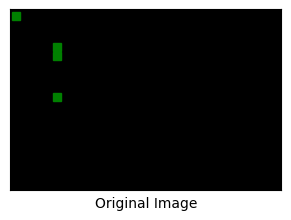

In [77]:
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray,
          vmin=0, vmax=255)
for (y, x) in cell_location:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

In [76]:
ax = fig.add_subplot(3, 2, 2)
ax.plot(dis_simm[:len(cell_patches)], corr[:len(cell_patches)], 'go',
        label='Cells')
ax.plot(dis_simm[len(cell_patches):], corr[len(cell_patches):], 'bo',
        label='Scratch')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(cell_patches):
    ax = fig.add_subplot(3, len(cell_patches), len(cell_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('Cells %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

### GLCM on large dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2 as cv
import os
import seaborn as sns
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy

In [3]:
print(os.listdir("image/"))

['.DS_Store', 'train', 'validation']


In [60]:
SIZE = 128

# Setup train list:-
train_img = []
train_labels = []

for directory_path in glob.glob("image/train/*"):
    label = os.path.basename(directory_path)
    print(label)
    for image_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(image_path)
        img = cv.imread(image_path, 0)
        if img is None:
            print("Error: Unable to read image at path:", image_path)
            continue
        if img.size == 0:
            print("Error: Empty image at path:", image_path)
            continue
        img = cv.resize(img, (SIZE, SIZE))
        train_img.append(img)
        train_labels.append(label)

train_img = np.array(train_img)
train_labels = np.array(train_labels)

sunrise
image/train/sunrise/R97U8MJI3D4J.jpg
image/train/sunrise/sunrise44_jpg.rf.fef99096ac65566c057479b257973d32.jpg
image/train/sunrise/sunrise334_jpg.rf.0aacd9f7c17271e3cb60584350f1a27a.jpg
image/train/sunrise/sunrise323_jpg.rf.e04f70c7d2860c0f1ea01d88551d2ca4.jpg
image/train/sunrise/sunrise33.jpg
image/train/sunrise/sunrise27.jpg
image/train/sunrise/shine22.jpg
image/train/sunrise/shine36.jpg
image/train/sunrise/sunrise250_jpg.rf.7eec41084afc610f24838fcd55a1431d.jpg
image/train/sunrise/A1QNVBQSG7EV.jpg
image/train/sunrise/sunrise233_jpg.rf.84f0cd891f4119e732d7a2f734c51348.jpg
image/train/sunrise/sunrise203.jpg
image/train/sunrise/sunrise217.jpg
image/train/sunrise/H92O69MVE45W.jpg
image/train/sunrise/THV37KNFLZOS.jpg
image/train/sunrise/sunrise91_jpg.rf.0e1b1808f3437297d0e7f32c39c6a536.jpg
image/train/sunrise/sunrise159_jpg.rf.b27847514600207731d346a37864a1d6.jpg
image/train/sunrise/sunrise49_jpg.rf.97520df0d717670ef1ea0706abb1a365.jpg
image/train/sunrise/20R40BNNTIL8.jpg
image/tr

4254

In [61]:
len(train_labels)

4254

In [5]:
test_img = []
test_labels = []

for directory_path in glob.glob("image/validation/*"):
    label = os.path.basename(directory_path)
    print(label)
    for image_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(image_path)
        img = cv.imread(image_path, 0)
        if img is None:
            print("Error: Unable to read image at path:", image_path)
            continue
        if img.size == 0:
            print("Error: Empty image at path:", image_path)
            continue
        img = cv.resize(img, (SIZE, SIZE))
        test_img.append(img)
        test_labels.append(label)

test_img = np.array(test_img)
test_labels = np.array(test_labels)

sunrise
image/validation/sunrise/P7O4QILDPWAT.jpg
image/validation/sunrise/EGZAEVVLFH1E.jpg
image/validation/sunrise/CN6LAO8FLP2L.jpg
image/validation/sunrise/8QEGDMI01W2C.jpg
image/validation/sunrise/IWT6T82QCKS4.jpg
image/validation/sunrise/KIJPBZCSI3GK.jpg
image/validation/sunrise/NWY4L28MM8I3.jpg
image/validation/sunrise/MZ9D5PKWSKW2.jpg
image/validation/sunrise/1C9ZGKBFZCZK.jpg
image/validation/sunrise/1V0J0IQ3DT7H.jpg
image/validation/sunrise/MVPPQBTWTHWD.jpg
image/validation/sunrise/7AWDI37S27QR.jpg
image/validation/sunrise/WOAP8U1DIJE3.jpg
image/validation/sunrise/SMI1UGGMHVCE.jpg
image/validation/sunrise/433YKT7E9NF3.jpg
image/validation/sunrise/VMKADDXUHMKX.jpg
image/validation/sunrise/OVBRC7RLENN8.jpg
image/validation/sunrise/OL2JXZ39WPI9.jpg
image/validation/sunrise/F6Q02Q6QH4MT.jpg
image/validation/sunrise/EHJMYQPUIVD2.jpg
image/validation/sunrise/YAEBE3VW30WW.jpg
image/validation/sunrise/N1MOPPUBLQYF.jpg
image/validation/sunrise/QAHTSQ16BUW6.jpg
image/validation/sunrise/X

In [6]:
len(test_img)

1206

In [7]:
from sklearn import preprocessing

In [44]:
# lable the labels with integers from texts

le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [56]:
# assign the train test split data

x_train, y_train, x_test, y_test = train_img,train_labels_encoded,test_img,test_labels_encoded

# normlise the value b/w [0,1]
x_train,x_test = x_train/255.0,x_test/255.0

In [47]:
def feature_extractor(dataset):
    img_dataset = pd.DataFrame()
    for images in range(dataset.shape[0]):
        df = pd.DataFrame()
        img = dataset[images,:,:]
        angles = [0, np.pi/4, np.pi/2]
        distances = [1, 3, 5]
        properties = ['energy', 'correlation', 'dissimilarity', 'homogeneity', 'contrast']
        image_dataset = pd.DataFrame()
        img_uint8 = (img * 255).astype(np.uint8)
        for i, distance in enumerate(distances):
            for j, angle in enumerate(angles):
                GLCM = graycomatrix(img_uint8, [distance], [angle])
                for prop in properties:
                    prop_value = graycoprops(GLCM, prop)[0]
                    df[f'{prop}_{i}_{j}'] = prop_value
                    image_dataset = pd.concat([image_dataset, df], ignore_index=True)
    return image_dataset

In [48]:
image_feature = feature_extractor(x_train)

In [49]:
 print(image_feature.shape)

(45, 45)


In [50]:
print(image_feature.head)

<bound method NDFrame.head of     energy_0_0  correlation_0_0  dissimilarity_0_0  homogeneity_0_0  \
0     0.020998              NaN                NaN              NaN   
1     0.020998         0.989097                NaN              NaN   
2     0.020998         0.989097           4.475332              NaN   
3     0.020998         0.989097           4.475332         0.248774   
4     0.020998         0.989097           4.475332         0.248774   
5     0.020998         0.989097           4.475332         0.248774   
6     0.020998         0.989097           4.475332         0.248774   
7     0.020998         0.989097           4.475332         0.248774   
8     0.020998         0.989097           4.475332         0.248774   
9     0.020998         0.989097           4.475332         0.248774   
10    0.020998         0.989097           4.475332         0.248774   
11    0.020998         0.989097           4.475332         0.248774   
12    0.020998         0.989097           4.475

In [51]:
image_feature.isnull().sum()

energy_0_0            0
correlation_0_0       1
dissimilarity_0_0     2
homogeneity_0_0       3
contrast_0_0          4
energy_0_1            5
correlation_0_1       6
dissimilarity_0_1     7
homogeneity_0_1       8
contrast_0_1          9
energy_0_2           10
correlation_0_2      11
dissimilarity_0_2    12
homogeneity_0_2      13
contrast_0_2         14
energy_1_0           15
correlation_1_0      16
dissimilarity_1_0    17
homogeneity_1_0      18
contrast_1_0         19
energy_1_1           20
correlation_1_1      21
dissimilarity_1_1    22
homogeneity_1_1      23
contrast_1_1         24
energy_1_2           25
correlation_1_2      26
dissimilarity_1_2    27
homogeneity_1_2      28
contrast_1_2         29
energy_2_0           30
correlation_2_0      31
dissimilarity_2_0    32
homogeneity_2_0      33
contrast_2_0         34
energy_2_1           35
correlation_2_1      36
dissimilarity_2_1    37
homogeneity_2_1      38
contrast_2_1         39
energy_2_2           40
correlation_2_2 

In [15]:
image_feature.fillna(image_feature['energy_0_0'].mean(),inplace=True)

In [18]:
X_for_ML =image_feature

In [19]:
 print(image_feature.shape)

(45, 45)


In [66]:
random_indices = np.random.permutation(len(train_img))
train_img_shuffled = train_img[random_indices]
train_labels_shuffled = train_labels[random_indices]
num_samples = 45
y_for_ML = train_labels_shuffled[:num_samples]

In [76]:
le = preprocessing.LabelEncoder()
le.fit(y_for_ML)

LabelEncoder()

In [77]:
len(y_for_ML_encoded)

1206

In [21]:
import lightgbm as lgb

In [69]:
d_train = lgb.Dataset(X_for_ML, label=y_for_ML)

lgbm_params = {'learning_rate':0.05, 'boosting_type':'dart',    
              'objective':'multiclass',
              'metric': 'multi_logloss',
              'num_leaves':100,
              'max_depth':10,
              'num_class':4} 

In [42]:
nan_count = np.isnan(y_train).sum()

print("Number of NaN values in y_train:", nan_count)

Number of NaN values in y_train: 0


In [68]:
print(len(X_for_ML), len(y_for_ML))

45 45


In [70]:
lgb_model = lgb.train(lgbm_params, d_train, 100)

ValueError: could not convert string to float: 'barn'

In [ ]:
test_features = feature_extractor(x_test)
test_features = np.expand_dims(test_features, axis=0)
test_for_RF = np.reshape(test_features, (x_test.shape[0], -1))
test_prediction = lgb_model.predict(test_for_RF)
test_prediction=np.argmax(test_prediction, axis=1)
#Inverse le transform to get original label back. 
test_prediction = le.inverse_transform(test_prediction)

In [ ]:
from sklearn import metrics

In [ ]:
print ("Accuracy = ", metrics.accuracy_score(test_labels, test_prediction))

In [ ]:
 print(image_feature.shape)